In [ ]:
# Install latest version from GitHub
# !pip install -q -U git+https://github.com/jdvelasq/techminer

In [82]:
import json

import matplotlib.pyplot as plt
import pandas as pd

from techminer import (
    DataFrame,
    Keywords,
    Map,
    Plot,
    Thesaurus,
    extract_country,
    heatmap,
    prepare_scopus_data,
    text_clustering,
)

# Data preparation

In [2]:
#
# Carga de datos
#
filepath = (
    "https://raw.githubusercontent.com/jdvelasq/techminer/master/data/papers"
    + "urban-agriculture.csv"
)
filepath = "../data/papers/urban-agriculture.csv"
df = pd.read_csv(filepath)
df = df.applymap(lambda x: None if pd.isna(x) is True else x)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Authors                        688 non-null    object 
 1   Author(s) ID                   688 non-null    object 
 2   Title                          688 non-null    object 
 3   Year                           688 non-null    int64  
 4   Source title                   688 non-null    object 
 5   Volume                         602 non-null    object 
 6   Issue                          444 non-null    object 
 7   Art. No.                       132 non-null    object 
 8   Page start                     544 non-null    object 
 9   Page end                       542 non-null    object 
 10  Page count                     9 non-null      float64
 11  Cited by                       453 non-null    float64
 12  DOI                            574 non-null    obj

In [3]:
#
# Scopus data preparation
#
#   1. Change ',' by ';' and remove '.' in author names
#   2. Remove part of title in foreign language
#   3. Keywords = Author Keywords + Index Keywords
#   4. Extract country and affiliation
#
df = prepare_scopus_data(df)

In [13]:
#
# Author desambiguation
#
df = DataFrame(df).disambiguate_authors()

In [4]:
#
# Number of records without Keywords
#
len(df[df.Keywords.map(lambda x: x is None)])

59

In [5]:
#
# Titles of documents without keywords
#
df[df.Keywords.map(lambda x: x is None)]["Title"]

11     Structure of urban bioecoagrocentres in contex...
43     Gardening in Times of Urban Transitions: Emerg...
47     Chinampas: An urban farming model of the aztec...
58     Direct and indirect effects of urban gardening...
77     IOP Conference Series: Earth and Environmental...
94     Use-Based Welfare: Property Experiments in Chi...
141                                       Toward sitopia
206    IOP Conference Series: Earth and Environmental...
225                          Politics of urban gardening
275    Integrated vertical aeroponic farming systems ...
284    Brucellosis in livestock and wildlife: Zoonoti...
286    Urban gardening between agency and structure: ...
322    Land tenure for urban farming: Toward a scalab...
335    Political consumers as digital food activists?...
336                     Urban sustainability transitions
341    Good food, strong communities: Promoting socia...
359                               Urban farming movement
384         Low lead poisoning 

In [6]:
#
# Build keywords from other papers
#
keywords = Keywords(df.Keywords[df.Keywords.map(lambda w: w is not None)], sep=";")
keywords = keywords.compile()
title_abstract = df.Title + df.Abstract
opt_keywords = title_abstract.map(lambda w: keywords.extract_from_text(w))

# check
opt_keywords[df.Keywords.map(lambda w: w is None)].head()

11    accessibility;air;article;cities;city;context;...
43    Cultivation;Entrepreneur;Garden;Gardening;New ...
47    China;City;Farmers;Horticultural;Science;Urban...
58    Soil moisture;Switzerland;Urban gardens;abunda...
77    Environment;Environmental;Environmental Scienc...
dtype: object

In [7]:
#
# Assign new keywords
#
df.at[df.Keywords.map(lambda w: w is None), "Keywords"] = opt_keywords[
    df.Keywords.map(lambda w: w is None)
]

#
# Check: Number of records without Keywords
#
len(df[df.Keywords.map(lambda x: x is None)])

0

In [8]:
#
# Text clustering of keywords.
#   Keyword strings with the same number of words
#
thesaurus = text_clustering(df.Keywords, sep=";", transformer=lambda x: x.lower())
with open("urban-agriculture-raw.json", "w") as f:
    f.write(thesaurus.__repr__())

In [9]:
!head -n 20 urban-agriculture-raw.json

{
  "abiotic factors": [
    "Abiotic factors",
    "abiotic factor"
  ],
  "abortion, veterinary": [
    "Abortion, Veterinary",
    "veterinary abortion"
  ],
  "acceptance": [
    "Acceptance",
    "acceptance"
  ],
  "accra, ghana": [
    "Accra, Ghana",
    "Accra-Ghana"
  ],
  "action research": [
    "Action research",
    "action research",


In [10]:
#
# Keywords cleaning
#
f = thesaurus.to_dict()
df["Keywords"] = df.Keywords.map(
    lambda x: ";".join([f[w] for w in x.split(";") if w in f])
)

#
#   Remove extra blanks between keywords if exists
#
df["Keywords"] = df.Keywords.map(
    lambda x: ";".join(set([w.strip() for w in x.split(";")]))
)

#
#   Replace empty strings by None
#
df["Keywords"] = df.Keywords.map(lambda x: x if x != "" else None)

#
#   Number of unique of strings
#
len(set([w.strip() for x in df.Keywords if x is not None for w in x.split(";")]))

848

In [11]:
#
# A column for identify each record is added to the dataframe.
#
df = DataFrame(df).generate_ID()

# Descriptive Statistics

In [12]:
#
# Number of terms
#
df.descriptive_stats()

,Value
Description,
Articles,688.000000
First year,1984.000000
Last year,2020.000000
Average citations per article,15.320088
Authors,1870.000000
Author(s) ID,1859.000000
Authors of single authored articles,192.000000
Authors of multi authored articles,496.000000
Articles per author,0.370000


# First Frequency Analysis

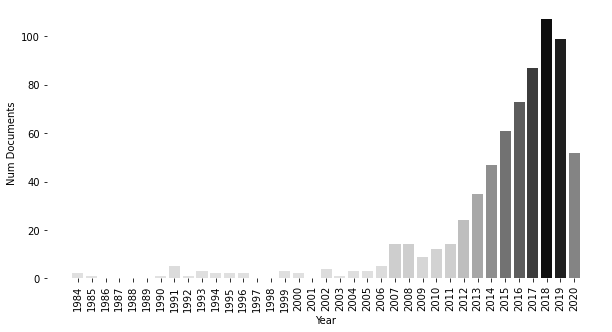

In [117]:
#
# Documents by year
#
plt.figure(figsize=(10, 5))
Plot(df.documents_by_year()).bar(cmap=plt.cm.Greys)

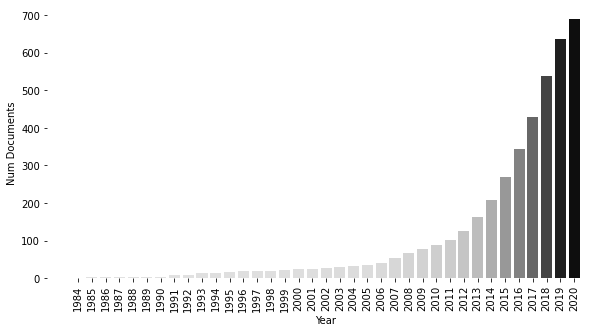

In [116]:
#
# Cumulative number of documents by year
#
plt.figure(figsize=(10, 5))
Plot(df.documents_by_year(cumulative=True)).bar(cmap=plt.cm.Greys)

In [46]:
#
# Document Types
#
df.documents_by_term("Document Type")

,Document Type,Num Documents,ID
0,Article,490,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16,..."
1,Conference Paper,110,"[11, 12, 15, 17, 18, 29, 30, 52, 53, 61, 62, 6..."
2,Book Chapter,36,"[38, 40, 45, 141, 146, 171, 224, 225, 226, 228..."
3,Review,29,"[35, 42, 48, 49, 93, 94, 136, 169, 212, 216, 2..."
4,Book,6,"[336, 341, 577, 582, 589, 654]"
5,Article in Press,3,"[185, 195, 215]"
6,Conference Review,3,"[77, 206, 556]"
7,Editorial,3,"[221, 476, 539]"
8,Note,3,"[284, 375, 557]"
9,Short Survey,3,"[501, 603, 618]"


In [39]:
#
#  Most frequent authors
#
df.documents_by_term("Authors").head(10)

,Authors,Num Documents,ID
0,[No author name available],8,"[77, 206, 556, 557, 563, 603, 650, 686]"
1,Polling B,6,"[261, 289, 324, 346, 396, 448]"
2,Utzinger J,6,"[282, 356, 358, 610, 641, 648]"
3,Certoma C,5,"[13, 97, 316, 367, 591]"
4,Cisse G,5,"[282, 356, 358, 641, 648]"
5,Lehmann S,5,"[137, 234, 583, 595, 596]"
6,Randhawa MA,5,"[150, 247, 370, 430, 517]"
7,Specht K,5,"[79, 81, 383, 412, 451]"
8,Tan HTW,5,"[2, 3, 21, 73, 253]"
9,Asomani-Boateng R,4,"[635, 662, 667, 668]"


In [14]:
#
# Top 10 most frequent authors
#
sorted(df.documents_by_term("Authors").head(10).Authors)

['Asomani-Boateng R',
 'Certoma C',
 'Cisse G',
 'Lehmann S',
 'Polling B',
 'Randhawa MA',
 'Specht K',
 'Tan HTW',
 'Utzinger J',
 '[No author name available]']

In [40]:
#
#  Most frequent sources
#
df.documents_by_term("Source title").head(10)

,Source title,Num Documents,ID
0,Acta Horticulturae,29,"[50, 163, 164, 165, 166, 167, 168, 258, 275, 2..."
1,Sustainability (Switzerland),26,"[44, 56, 67, 71, 78, 79, 81, 85, 86, 114, 115,..."
2,IOP Conference Series: Earth and Environmental...,20,"[12, 15, 17, 18, 29, 30, 63, 69, 70, 75, 76, 7..."
3,Urban Forestry and Urban Greening,15,"[6, 20, 59, 119, 120, 154, 176, 181, 213, 253,..."
4,Science of the Total Environment,11,"[3, 4, 88, 106, 152, 172, 200, 338, 358, 363, ..."
5,Renewable Agriculture and Food Systems,10,"[155, 156, 215, 435, 451, 455, 458, 474, 478, ..."
6,Landscape and Urban Planning,9,"[5, 101, 158, 217, 220, 221, 285, 428, 559]"
7,Local Environment,9,"[23, 227, 271, 287, 450, 452, 465, 493, 591]"
8,Agronomy for Sustainable Development,8,"[219, 351, 362, 381, 382, 383, 431, 531]"
9,IOP Conference Series: Materials Science and E...,8,"[11, 61, 109, 110, 111, 266, 270, 309]"


In [41]:
#
#  Most frequent institutions
#
df.documents_by_term("Institution").head(10)

,Institution,Num Documents,ID
0,,420,"[8, 9, 11, 12, 15, 17, 18, 19, 22, 23, 24, 28,..."
1,Massachusetts Institute of Technology,3,"[288, 297, 382]"
2,National Institute of Education,3,"[275, 536, 578]"
3,Institute of Biology; Research Institute of O...,2,"[160, 194]"
4,Institute of Socio-Economics,2,"[383, 412]"
5,Kenya Agricultural Research Institute,2,"[608, 612]"
6,Singapore Institute of Technology,2,"[80, 325]"
7,Geographisches Institut,2,"[37, 552]"
8,Institut fur Geographie,2,"[479, 480]"
9,Institute of European and American Studies,2,"[264, 312]"


In [42]:
#
#  Most frequent countries
#
df.documents_by_term("Country").head(10)

,Country,Num Documents,ID
0,United States,74,"[31, 38, 43, 47, 66, 84, 141, 175, 178, 184, 1..."
1,United States;United States,30,"[40, 62, 64, 90, 92, 196, 231, 236, 277, 278, ..."
2,Germany,27,"[19, 20, 37, 118, 129, 163, 176, 233, 268, 286..."
3,Indonesia,17,"[12, 17, 18, 24, 52, 63, 131, 214, 222, 232, 2..."
4,Italy,16,"[134, 157, 167, 257, 351, 355, 359, 367, 392, ..."
5,United States;United States;United States,13,"[5, 46, 48, 218, 271, 372, 378, 393, 405, 440,..."
6,Australia,11,"[9, 124, 204, 363, 459, 497, 518, 562, 583, 59..."
7,Italy;Italy,10,"[44, 45, 119, 136, 152, 193, 300, 345, 381, 600]"
8,South Africa,10,"[32, 144, 409, 414, 513, 545, 625, 640, 649, 651]"
9,United Kingdom,10,"[128, 135, 221, 349, 375, 507, 515, 564, 620, ..."


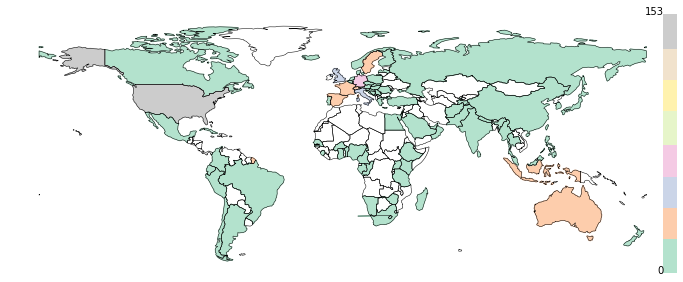

In [26]:
#
# Most frequent countries
#
plt.figure(figsize=(12, 5))
Plot(df.documents_by_term("Country", sep=";")).worldmap()
plt.show()

In [43]:
#
#  Most frequent keywords
#
df.documents_by_term("Keywords").head(10)

,Keywords,Num Documents,ID
0,urban agriculture,203,"[0, 3, 4, 7, 8, 9, 20, 26, 27, 31, 32, 36, 46,..."
1,urban farm,180,"[9, 17, 21, 22, 24, 26, 33, 34, 35, 43, 47, 49..."
2,urban garden,112,"[1, 7, 13, 14, 20, 32, 39, 43, 58, 77, 89, 96,..."
3,garden,101,"[4, 6, 19, 20, 40, 43, 58, 64, 77, 85, 89, 91,..."
4,urban,99,"[11, 43, 47, 58, 67, 77, 81, 85, 94, 118, 141,..."
5,urban areas,99,"[3, 4, 5, 6, 13, 16, 28, 44, 60, 64, 85, 88, 1..."
6,agriculture,93,"[7, 24, 27, 29, 42, 47, 49, 53, 62, 70, 95, 10..."
7,sustainability,70,"[9, 23, 38, 45, 47, 57, 62, 67, 74, 78, 79, 81..."
8,article,62,"[3, 4, 11, 19, 28, 60, 64, 88, 94, 106, 121, 1..."
9,food security,61,"[9, 38, 48, 49, 53, 63, 65, 82, 124, 131, 154,..."


# First level citation analysis

In [37]:
#
# Most cited documents
#
df.most_cited_documents().head(10)

,Title,Authors,Year,Cited by,ID
493,"Radical, reformist, and garden-variety neolibe...",McClintock N,2014,215,493
604,Why farm the city? Theorizing urban agricultur...,McClintock N,2010,182,604
678,Urban agriculture for sustainable cities: Usin...,Smit J;Nasr J,1992,177,678
551,"Urban gardens, Agriculture, And water manageme...",Barthel S;Isendahl C,2013,166,551
531,Urban agriculture in the developing world: A r...,Orsini F;Kahane R;Nono-Womdim R;Gianquinto G,2013,151,531
654,"Agropolis: The social, political, and environm...",Mougeot LJ,2005,151,654
664,Public health implications of urban agriculture,Brown KH;Jameton AL,2000,149,664
507,Critical geography of urban agriculture,Tornaghi C,2014,132,507
559,Civic greening and environmental learning in p...,Bendt P;Barthel S;Colding J,2013,121,559
447,Food and Green Space in Cities: A Resilience L...,Barthel S;Parker J;Ernstson H,2015,107,447


In [47]:
#
# Top 10 most cited authors
#
df.citations_by_term("Authors").head(10)

,Authors,Cited by,ID
0,McClintock N,397,"[493, 604]"
1,Barthel S,394,"[447, 551, 559]"
2,Utzinger J,269,"[282, 356, 358, 610, 641, 648]"
3,Matthys B,229,"[610, 641, 648]"
4,N'Goran EK,229,"[610, 641, 648]"
5,Vounatsou P,229,"[610, 641, 648]"
6,Cisse G,184,"[282, 356, 358, 641, 648]"
7,Nasr J,177,[678]
8,Smit J,177,[678]
9,Gianquinto G,168,"[79, 351, 427, 531]"


In [48]:
#
#  Most cited sources
#
df.citations_by_term("Source title").head(10)

,Source title,Cited by,ID
0,Agronomy for Sustainable Development,345,"[219, 351, 362, 381, 382, 383, 431, 531]"
1,Local Environment,278,"[23, 227, 271, 287, 450, 452, 465, 493, 591]"
2,Sustainability (Switzerland),260,"[44, 56, 67, 71, 78, 79, 81, 85, 86, 114, 115,..."
3,Landscape and Urban Planning,215,"[5, 101, 158, 217, 220, 221, 285, 428, 559]"
4,Environment & Urbanization,209,"[674, 678]"
5,Renewable Agriculture and Food Systems,190,"[155, 156, 215, 435, 451, 455, 458, 474, 478, ..."
6,"Cambridge Journal of Regions, Economy and Society",182,[604]
7,Ecological Economics,166,[551]
8,"Agropolis: The Social, Political and Environme...",151,[654]
9,Urban Forestry and Urban Greening,150,"[6, 20, 59, 119, 120, 154, 176, 181, 213, 253,..."


In [49]:
#
#  Most cited institutions
#
df.citations_by_term("Institution").head(10)

,Institution,Cited by,ID
0,,3966,"[8, 9, 11, 12, 15, 17, 18, 19, 22, 23, 24, 28,..."
1,The Beijer Institute of Ecological Economics,166,[551]
2,International Development Research Centre,151,[654]
3,University of Leeds,132,[507]
4,Beijer Institute of Ecological Economics,121,[559]
5,Institute of Earth Sciences; Institute of Sus...,99,[461]
6,Institute of Plant Sciences and Resource Conse...,97,[431]
7,Institute of Socio-Economics; Inter 3 Institu...,88,[451]
8,Swiss Tropical Institute; Swedish Institute f...,85,[610]
9,Swiss Tropical Institute; Queensland Institut...,79,[648]


In [51]:
#
#  Most cited countries
#
df.citations_by_term("Country", sep=";").head(10)

,Country,Cited by,ID
0,United States,2500,"[4, 5, 27, 31, 38, 40, 42, 43, 46, 47, 48, 62,..."
1,Germany,898,"[7, 19, 20, 27, 37, 42, 54, 57, 58, 60, 68, 79..."
2,Sweden,750,"[56, 78, 93, 273, 301, 311, 376, 429, 434, 446..."
3,United Kingdom,547,"[26, 42, 49, 53, 67, 116, 128, 135, 137, 154, ..."
4,Switzerland,474,"[6, 58, 70, 73, 106, 160, 181, 194, 198, 217, ..."
5,Italy,447,"[42, 44, 45, 51, 79, 97, 119, 134, 136, 152, 1..."
6,,393,"[76, 105, 282, 356, 358, 610, 638, 641, 648, 659]"
7,France,326,"[8, 86, 87, 147, 164, 168, 190, 210, 219, 223,..."
8,Australia,317,"[2, 3, 9, 53, 124, 161, 187, 204, 333, 336, 36..."
9,Canada,289,"[93, 107, 225, 373, 403, 438, 473, 510, 526, 5..."


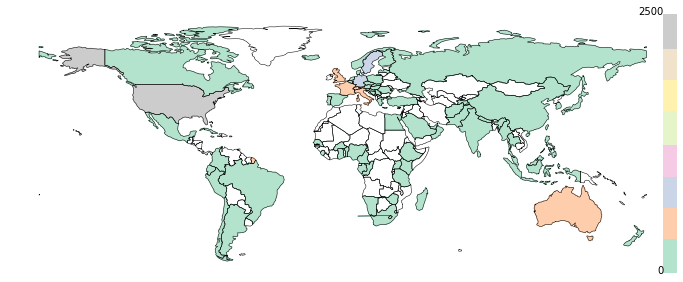

In [52]:
#
# Most frequent countries
#
plt.figure(figsize=(12, 5))
Plot(df.citations_by_term("Country", sep=";")).worldmap()
plt.show()

In [53]:
#
#  Most cited keywords
#
df.citations_by_term("Keywords").head(10)

,Keywords,Cited by,ID
0,urban agriculture,3125,"[0, 3, 4, 7, 8, 9, 20, 26, 27, 31, 32, 36, 46,..."
1,urban farm,1509,"[9, 17, 21, 22, 24, 26, 33, 34, 35, 43, 47, 49..."
2,urban areas,1327,"[3, 4, 5, 6, 13, 16, 28, 44, 60, 64, 85, 88, 1..."
3,food security,1208,"[9, 38, 48, 49, 53, 63, 65, 82, 124, 131, 154,..."
4,garden,1198,"[4, 6, 19, 20, 40, 43, 58, 64, 77, 85, 89, 91,..."
5,article,1139,"[3, 4, 11, 19, 28, 60, 64, 88, 94, 106, 121, 1..."
6,urban,1090,"[11, 43, 47, 58, 67, 77, 81, 85, 94, 118, 141,..."
7,urban garden,1087,"[1, 7, 13, 14, 20, 32, 39, 43, 58, 77, 89, 96,..."
8,agriculture,991,"[7, 24, 27, 29, 42, 47, 49, 53, 62, 70, 95, 10..."
9,sustainability,934,"[9, 23, 38, 45, 47, 57, 62, 67, 74, 78, 79, 81..."


# Second level frequency analysis

In [63]:
#
# Top 10 frequent tems
#
top_10_freq_authors = Keywords(df.documents_by_term("Authors").head(10).Authors)
top_10_freq_sources = Keywords(
    df.documents_by_term("Source title").head(10)["Source title"]
)
top_10_freq_institutions = Keywords(
    df.documents_by_term("Institution", sep=";").head(10)["Institution"]
)
top_10_freq_country = Keywords(
    df.documents_by_term("Country", sep=";").head(10).Country
)
top_10_freq_keywords = Keywords(df.documents_by_term("Keywords").head(10).Keywords)

## Frequency by year

In [84]:
df.documents_by_term_per_year("Authors", as_matrix=True, keywords=top_10_freq_authors)

,Asomani-Boateng R,Certoma C,Cisse G,Lehmann S,Polling B,Randhawa MA,Specht K,Tan HTW,Utzinger J,[No author name available]
1984,0,0,0,0,0,0,0,0,0,1
1999,2,0,0,0,0,0,0,0,0,0
2002,1,0,0,0,0,0,0,0,0,0
2006,0,0,1,0,0,0,0,0,1,1
2007,1,0,1,0,0,0,0,0,1,0
2010,0,0,0,0,0,0,0,0,1,1
2011,0,1,0,2,0,0,0,0,0,0
2012,0,0,0,1,0,0,0,0,0,1
2013,0,0,0,0,0,0,0,0,0,2
2014,0,0,0,0,0,1,0,0,0,0


In [86]:
df.documents_by_term_per_year(
    "Source title", as_matrix=True, keywords=top_10_freq_sources
)

,Acta Horticulturae,Agronomy for Sustainable Development,IOP Conference Series: Earth and Environmental Science,IOP Conference Series: Materials Science and Engineering,Landscape and Urban Planning,Local Environment,Renewable Agriculture and Food Systems,Science of the Total Environment,Sustainability (Switzerland),Urban Forestry and Urban Greening
2004,1,0,0,0,0,0,1,0,0,0
2007,2,0,0,0,0,0,0,0,0,0
2008,1,0,0,0,0,0,0,0,0,0
2010,2,0,0,0,0,0,0,0,0,0
2011,1,0,0,0,0,1,0,0,0,0
2012,1,0,0,0,0,0,0,0,0,0
2013,4,1,0,0,1,0,0,0,0,0
2014,4,0,0,0,0,1,0,0,0,0
2015,3,1,0,0,1,3,6,0,1,1
2016,0,5,0,0,0,0,0,3,5,3


In [89]:
df.documents_by_term_per_year(
    "Institution", sep=";", as_matrix=True, keywords=top_10_freq_institutions
)

,COMSATS Institute of Information Technology,Institute of Biology,Institute of Biology and Schoolgarden Development,Institute of Socio-Economics,Institute of Terrestrial Ecosystems,International Livestock Research Institute,International Livestock Research InstituteHanoi,National Institute of Food Science and Technology,Research Institute of Organic Agriculture (FiBL),Swiss Federal Research Institute WSL,Swiss Tropical Institute
2006,0,0,0,0,0,0,0,0,0,0,1
2007,0,0,0,0,0,0,0,0,0,0,1
2010,0,0,0,0,0,0,0,0,0,0,2
2014,1,0,0,0,0,0,0,1,0,0,0
2015,1,0,0,1,0,0,0,1,0,0,0
2016,1,0,1,2,0,1,0,1,0,0,0
2017,0,1,0,0,0,0,1,0,0,0,0
2018,0,2,0,0,2,2,0,1,2,2,0
2019,0,2,0,0,2,0,0,0,2,2,0


In [91]:
df.documents_by_term_per_year(
    "Country", sep=";", as_matrix=True, keywords=top_10_freq_country
)

,Australia,France,Germany,Indonesia,Italy,Spain,Sweden,Switzerland,United Kingdom,United States
1984,0,1,0,0,0,0,0,0,0,0
1985,0,0,0,0,0,0,0,0,0,1
1991,0,0,0,0,0,0,0,0,0,1
1992,0,0,0,0,0,0,0,0,0,1
1993,0,0,0,0,0,0,0,0,0,1
1995,0,0,0,0,0,0,0,0,0,1
1996,0,0,0,0,0,0,0,0,0,1
1999,0,0,0,0,0,0,0,1,0,0
2000,0,0,0,0,0,0,0,0,0,1
2002,0,0,0,0,0,0,0,0,1,2


In [97]:
df.documents_by_term_per_year(
    "Keywords", sep=";", as_matrix=True, keywords=top_10_freq_keywords
)

,agriculture,agriculture development,allotment gardens,article,building integrated agriculture,closed loop urban metabolism,communal gardens,community supported agriculture,controlled environment agriculture,food gardening,...,urban regions,urban soil,urban space,urban sustainability,urban transition,urban vegetable farming,urban waste,urbanfarm,urbanisation,vertical gardening
1984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1993,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1995,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1999,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Occurrence Matrices

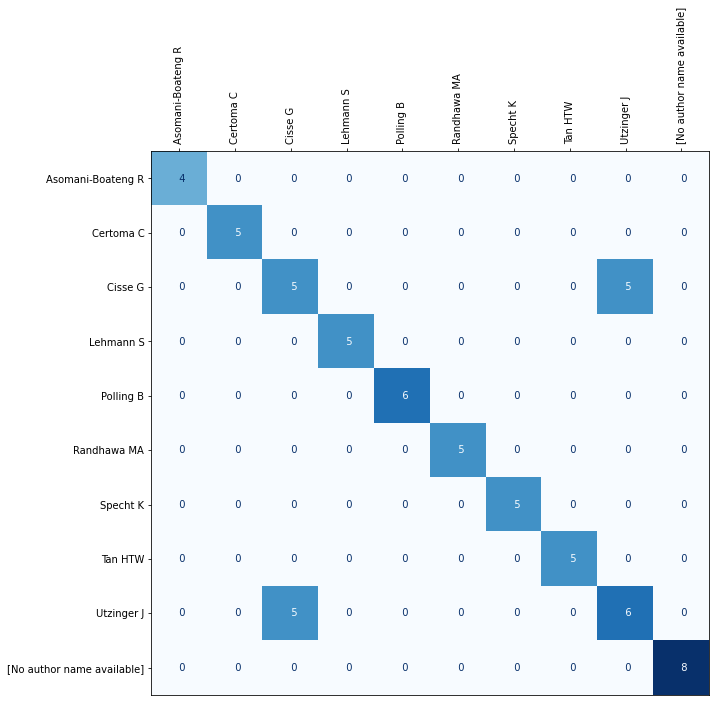

In [115]:
plt.figure(figsize=(10, 10))
Plot(df.occurrence("Authors", as_matrix=True, keywords=top_10_freq_authors)).heatmap(
    cmap="Blues"
)

In [73]:
#  df.occurrence('Source title', as_matrix=True, keywords=top_10_freq_sources)

In [74]:
# df.occurrence('Institution', sep=';', as_matrix=True, keywords=top_10_freq_institutions)

In [75]:
# df.occurrence('Country', sep=';', as_matrix=True, keywords=top_10_freq_country)

In [76]:
#  df.occurrence('Keywords', as_matrix=True, keywords=top_10_freq_keywords)

## Autocorrelations

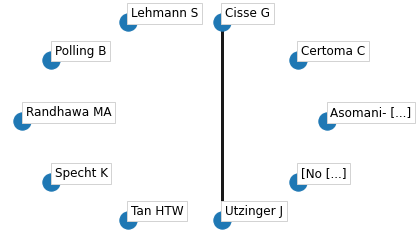

In [122]:
Map().correlation_map(**df.autocorr_map("Authors", keywords=top_10_freq_authors))

/usr/local/lib/python3.6/dist-packages/networkx/drawing/layout.py:730: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3),


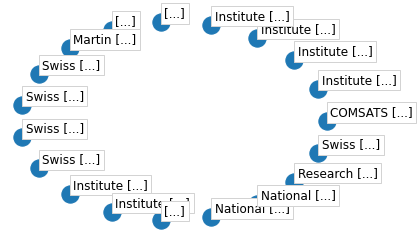

In [120]:
Map().correlation_map(
    **df.autocorr_map("Institution", keywords=top_10_freq_institutions)
)

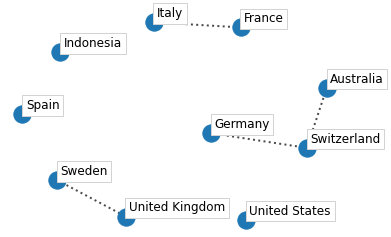

In [121]:
Map().correlation_map(
    **df.autocorr_map("Country", sep=";", keywords=top_10_freq_country)
)

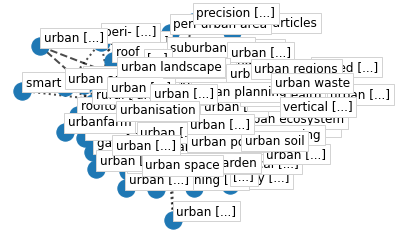

In [119]:
nxmap.correlation_map(
    **df.autocorr_map("Keywords", sep=";", keywords=top_10_freq_keywords)
)

## Factor Analysis

In [104]:
df.factor_analysis("Authors", n_components=5, keywords=top_10_freq_authors)

,F0,F1,F2,F3,F4
Asomani-Boateng R,-0.042087,-0.075575,-0.068585,-0.000000e+00,0.000000e+00
Certoma C,-0.063117,-0.133456,-0.193868,-1.410309e-01,-5.112217e-01
Cisse G,0.640209,0.111382,0.035381,4.163336e-17,9.714451e-17
Lehmann S,-0.063117,-0.133456,-0.193868,-4.539101e-02,7.137137e-01
Polling B,-0.094643,-0.272681,0.890160,5.689893e-16,-1.054712e-15
Randhawa MA,-0.063117,-0.133456,-0.193868,-5.436884e-01,-2.987662e-01
Specht K,-0.063117,-0.133456,-0.193868,8.210827e-01,-2.120259e-01
Tan HTW,-0.063117,-0.133456,-0.193868,-9.097243e-02,3.083001e-01
Utzinger J,0.704274,0.118654,0.036350,2.081668e-17,-1.665335e-16
[No author name available],-0.251959,0.896882,0.111417,3.122502e-16,-1.387779e-16


In [ ]:
#  df.factor_analysis('Institutions', n_components=5, keywords = top_10_freq_institutions)

In [ ]:
#  df.factor_analysis('Countries', n_components=5, keywords = top_10_freq_institutions)

In [ ]:
#  df.factor_analysis('Keywords', n_components=5, keywords = top_10_freq_keywords)

# Gant Diagram

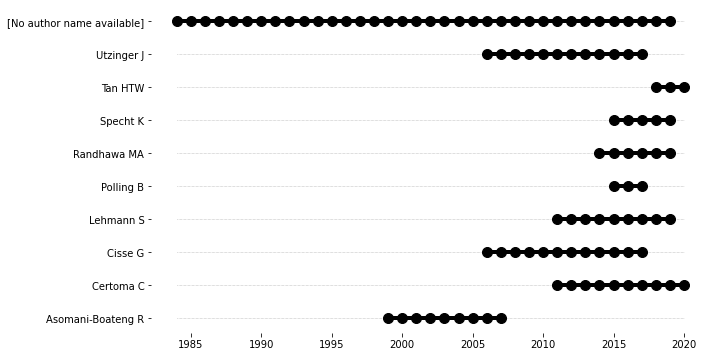

In [107]:
plt.figure(figsize=(10, 6))
Plot(df.gant("Authors", keywords=top_10_freq_authors)).gant()

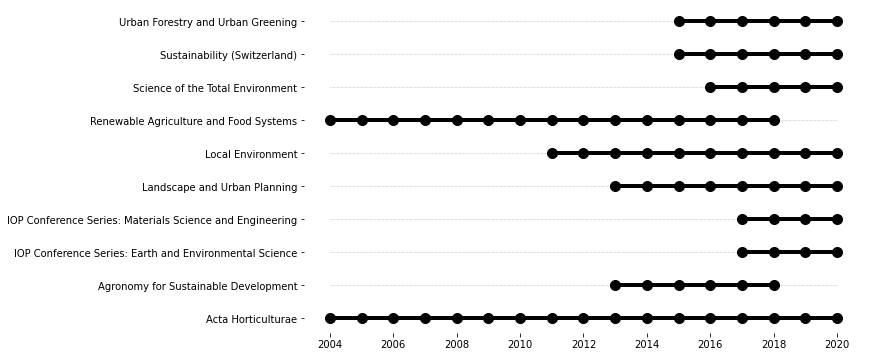

In [108]:
plt.figure(figsize=(10, 6))
Plot(df.gant("Source title", keywords=top_10_freq_sources)).gant()

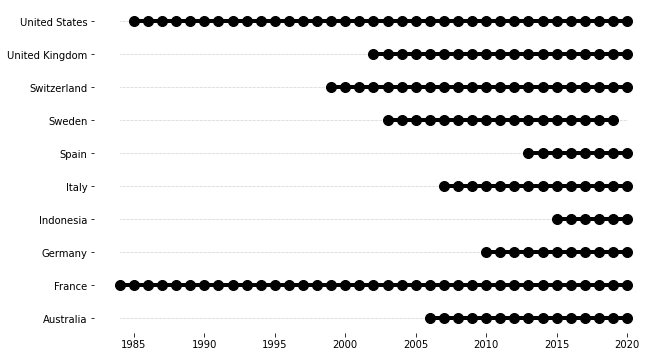

In [110]:
plt.figure(figsize=(10, 6))
Plot(df.gant("Country", sep=";", keywords=top_10_freq_country)).gant()

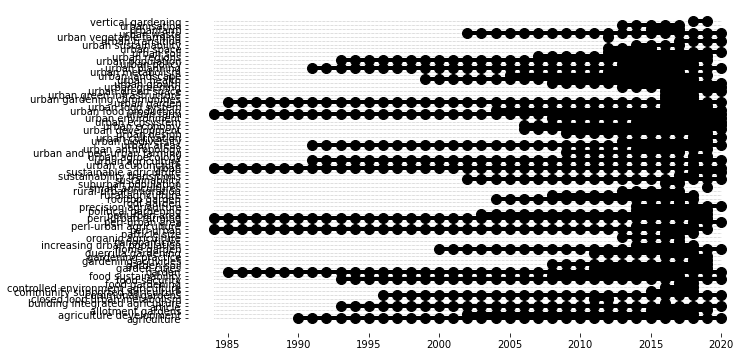

In [111]:
plt.figure(figsize=(10, 6))
Plot(df.gant("Keywords", sep=";", keywords=top_10_freq_keywords)).gant()

In [126]:
import ipywidgets as widgets

In [127]:
accordion = widgets.Accordion(children=[widgets.IntSlider(), widgets.Text()])
accordion.set_title(0, 'Slider')
accordion.set_title(1, 'Text')
accordion

Accordion(children=(IntSlider(value=0), Text(value='')), _titles={'0': 'Slider', '1': 'Text'})